| | |
| --- | --- |
| **Author** | Alessio Spurio Mancini |
| **email** | a.spuriomancini@ucl.ac.uk |

<div align="center"><img src='https://drive.google.com/uc?id=1KTafFIJzWQTBdtdd6xrI7OszfhpZYkVM' width="400" height="300"></div>

---
---
# **INTRODUCTION**
---
---

This notebook can also be run on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1eiDX_P0fxcuxv530xr2iceaPbY4CA5pD?usp=sharing)

In this notebook we will train a neural network emulator of Cosmic Microwave Background (CMB) power spectra, using the ``CosmoPower`` class ``cosmopower_NN``. As an example we will consider here emulation of **TT** temperature power spectra. Note that this just an example and the procedure is analogous for other CMB power spectra, as well as for the matter power spectrum.

<img src='https://drive.google.com/uc?id=1ldao4kWmzsbIRoGAXXRu65UYDSC8bLqQ'>

We denote with $\boldsymbol{w}$ the collection of weights and biases of the $n$ nodes in our NN, 
$\boldsymbol{w}= \{ \boldsymbol{W}_1, \boldsymbol{b}_1, \boldsymbol{W}_2, \boldsymbol{b}_2, \dots \boldsymbol{W}_n, \boldsymbol{b}_n \}$. 

$\boldsymbol{w}$ parameterizes the mapping between cosmological parameters $\boldsymbol{\theta}$ and power spectra $\boldsymbol{P}_\lambda$ ($= \boldsymbol{C}_\ell$ in this CMB case). 

**NOTE**: Whenever possible, we recommend taking the logarithm of the power spectra to reduce their dynamic range. The mapping learnt by the NN becomes then effectively a function between cosmological parameters and log-power spectra. 

If (as in this notebook!) log-spectra are used as training samples, ``cosmopower_NN`` has built-in methods that can be called to output either directly the log-spectra (sometimes this may be preferrable for e.g. interpolation), or the spectra obtained by exponentiating 10 to the output of the network (see an example of this in the "Testing" section of this notebook).  

---
---
# **PRELIMINARY OPERATIONS** 
---
---

We will start with a few imports, as well as with checking that the notebook is running on a GPU - this is strongly recommended to speed up training.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, clear_output

In [ ]:
# checking that we are using a GPU
device = 'gpu:0' if tf.test.is_gpu_available() else 'cpu'
print('using', device, 'device \n')

We will also set the random seed, for reproducibility of results. 

In [ ]:
# setting the seed for reproducibility
np.random.seed(1)
tf.random.set_seed(2)

---
---
# **TRAINING/TESTING DATA DOWNLOAD**
---
---

Here we will download the datasets for training and testing our emulator.

For the illustrative purposes of this notebook, we will use datasets of modest size. These are publicly shared via Google Drive links. Due to the size limits to file sharing via Google Drive, we uploaded the training and testing datasets used in [the CosmoPower release paper](https://arxiv.org/abs/2106.03846) on Zenodo. The user who wants to e.g. reproduce the results of the ``CosmoPower`` release paper is invited to download these files.

In [ ]:
# Download data
!gdown --id 1FERzMIinJjIPvITKFv6wzjZgm5Y5VeFv -O ./camb_tt_testing_params.npz
!gdown --id 16MSqQOxKqqmH37fV2e2vsVGx1rJO5YuQ -O ./camb_tt_testing_log_spectra.npz
!gdown --id 1KF5NLYs9DJ1W7yfE48BHaouHgj71Fd1i -O ./camb_tt_training_params.npz
!gdown --id 1QmvUnrOoT2roQAPUNgoRCTq46HJTwkR7 -O ./camb_tt_training_log_spectra.npz

Downloading...
From: https://drive.google.com/uc?id=1FERzMIinJjIPvITKFv6wzjZgm5Y5VeFv
To: /home/camb_tt_testing_params.npz
100% 459k/459k [00:00<00:00, 68.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=16MSqQOxKqqmH37fV2e2vsVGx1rJO5YuQ
To: /home/camb_tt_testing_log_spectra.npz
100% 191M/191M [00:01<00:00, 114MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KF5NLYs9DJ1W7yfE48BHaouHgj71Fd1i
To: /home/camb_tt_training_params.npz
100% 2.05M/2.05M [00:00<00:00, 63.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QmvUnrOoT2roQAPUNgoRCTq46HJTwkR7
To: /home/camb_tt_training_log_spectra.npz
100% 855M/855M [00:08<00:00, 99.0MB/s]


### **PARAMETER FILES**

Let's take a look at the content of these files, starting with the parameter samples of the training set.



In [ ]:
# training parameters
training_parameters = np.load('./camb_tt_training_params.npz')

`training_parameters` is a `dict` of `np.arrays`. There is a `dict` key for each of the parameters the emulator is going to be trained on:

In [ ]:
print(training_parameters.files)

['omega_b', 'omega_cdm', 'h', 'tau_reio', 'n_s', 'ln10^{10}A_s']


Each of these keys has a `np.array` of values: the number of elements in the array is the number of training samples in our set. For example:

In [ ]:
print(training_parameters['omega_b'])
print('number of training samples: ', len(training_parameters['omega_b'])) # same for all of the other parameters

[0.03959524 0.03194429 0.03467569 ... 0.03958164 0.02816863 0.01942146]
number of training samples:  42614


### **FEATURE FILES**

Now let's take a look at the "features". With features here we refer to the predictions of the neural network: these may be spectra or log-spectra values. In this case we are emulating values of the TT log-power spectra. These are sampled at each multipole $\ell$ in the range $[2, \dots 2508]$, hence our training sample for each log-spectrum will be a 2507-dimensional array. The corresponding `.npz` files contain a `dict` with two keys:

In [ ]:
# training features (= log-spectra, in this case)
training_features = np.load('./camb_tt_training_log_spectra.npz')
print(training_features.files)

['modes', 'features']


The first key, `modes`, contains a `np.array` of the sampled Fourier modes (multipoles, in this case):

In [ ]:
print(training_features['modes'])
print('number of multipoles: ', len(training_features['modes']))

[   2    3    4 ... 2506 2507 2508]
number of multipoles:  2507


The second key, `features`, has values equal to the actual values of the log-spectra. These are collected in a `np.array` of shape (number of training samples, number of Fourier modes):

In [ ]:
training_log_spectra = training_features['features']
print('(number of training samples, number of ell modes): ', training_log_spectra.shape)

(number of training samples, number of ell modes):  (42614, 2507)


The files for the testing samples have the same type of content, hence here we simply load them directly. Note that since we will be comparing the performance of our trained emulator with the testing set spectra (not the log-values), we store them in memory here from their log10 values.

In [ ]:
# testing parameters
testing_params = np.load('./camb_tt_testing_params.npz')
# testing features
testing_spectra = 10.**(np.load('./camb_tt_testing_log_spectra.npz')['features'])

---
---
# **`cosmopower_NN` INSTANTIATION**
---
---

We will now create an instance of the `cosmopower_NN class`, which we will subsequently train. 

In order to instantiate the class, we need to first define some of the key aspects of our model.

### **PARAMETERS** 

Let's start by defining the parameters of our model. `cosmopower_NN` will take in input a set of these parameters for each prediction. 

If, for example, we want to emulate over a set of 6 standard $\Lambda$CDM parameters,

$\omega_{\mathrm{b}}, \omega_{\mathrm{cdm}}, h, \tau, n_s, \ln10^{10}A_s$

we need to create a `list` with the names of all of these parameters, in _arbitrary_ order:     

In [ ]:
# list of parameter names, in arbitrary order
model_parameters = ['h', 
                    'tau_reio', 
                    'omega_b', 
                    'n_s', 
                    'ln10^{10}A_s', 
                    'omega_cdm', 
                    ]

This `list` will be sent in input to the `cosmopower_NN` class, which will use this information: 

- to derive the *number* of parameters in our model, equal to the number of elements in `model_parameters`. This number also corresponds to the number of nodes in the input layer of the neural network;

- to free the user from the burden of having to manually perform any ordering of the input parameters.

The latter point guarantees flexibility and simplicity while using `cosmopower_NN`: to obtain predictions for a set of parameters, the user simply needs to feed a Python `dict` to `cosmopower_NN`, without having to worry about the ordering of the input parameters. 

For example, if I wanted to know the neural network prediction for a single set of parameters, I would collect them in the following `dict`:

```python
example_single_set_input_parameters = {'n_s': [0.96], 
                                       'h': [0.7], 
                                       'omega_b': [0.0225], 
                                       'omega_cdm': [0.13], 
                                       'tau_reio': [0.06], 
                                       'ln10^{10}A_s': [3.07], 
                                        }
```

Similarly, if I wanted to ask `cosmopower_NN` for e.g. 3 predictions, for 3 parameter sets, I would use:

```python
example_multiple_sets_input_parameters = {'n_s': np.array([0.96, 0.95, 0.97]), 
                                          'h': np.array([0.7, 0.64, 0.72]), 
                                          'omega_b': np.array([0.0225, 0.0226, 0.0213]), 
                                          'omega_cdm': np.array([0.11, 0.13, 0.12]), 
                                          'tau_reio': np.array([0.07,0.06, 0.08]), 
                                          'ln10^{10}A_s': np.array([2.97, 3.07, 3.04]), 
                                           }
```
The possibility of asking `cosmopower_NN` for batch predictions, in particular, makes it a particularly useful tool to integrate within samples that allow for batch evaluations of the likelihood.

### **MODES**

A second, important piece of information for the `cosmopower_NN` class is the number of its output nodes, which corresponds to the number of sampled Fourier modes in our (log)-spectra, i.e. the number of multipoles $\ell$ for the CMB spectra, or the number of $k$-modes for the matter power spectrum.

In this example, we will emulate all of the $\ell$ multipoles between 2 and 2508. Note that we exclude $\ell=0,1$ as these are always 0. We can read the sampled $\ell$ range from the `modes` entry of our `training_features` dict (previously loaded):

In [ ]:
ell_range = training_features['modes']
print('ell range: ', ell_range)

ell range:  [   2    3    4 ... 2506 2507 2508]


### **CLASS INSTANTIATION**
Finally, let's feed the information on model parameters and number of outputs to the `cosmopower_NN`class, which we instantiate with the following:

In [ ]:
from cosmopower import cosmopower_NN

# instantiate NN class
cp_nn = cosmopower_NN(parameters=model_parameters, 
                      modes=ell_range, 
                      n_hidden = [512, 512, 512, 512], # 4 hidden layers, each with 512 nodes
                      verbose=True, # useful to understand the different steps in initialisation and training
                      )


Initialized cosmopower_NN model, 
mapping 6 input parameters to 2507 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 



---
---
# **TRAINING**
---
---

In this section we will train our model. 

To do this, we will call the method `train()` from the `cosmopower_NN` class.
Here are the input arguments for this function:

* `training_parameters`: as explained above, this is a `dict` of `np.arrays` of input parameters. Each `dict` key has a `np.array` of values, for example

```python
training_parameters = {`omega_b` : np.array([0.0222, 0.0213, 0.0241, ...]),
                       `omega_cdm` : np.array([0.114, 0.134, 0.124, ...]),
                        ... etc ...
                      }
```
(each `np.array` has the same number of elements, equal to the number of training samples);

* `training_features`: a `np.array` of training (log)-power spectra. Its dimensions are (number of training samples, number of Fourier modes);

* `filename_saved_model`: path (without suffix) to the `.pkl` file where the trained model will be saved;

* `validation split`: `float` between 0 and 1, percentage of samples from the training set that will be used for validation.


Some of the input arguments allow for the implementation of a learning schedule with different steps, each characterised by a different learning rate. In addition to the learning rate, the user can change other hyperparameters, such as the batch size, at each learning step:

* `learning_rates`: `list` of `float` values, the optimizer learning rate at each learning step;

* `batch_sizes`: `list` of `float` values, batch size for each learning step;

* `gradient_accumulation_steps`: `list` of `int` values, the number of accumulation batches if using gradient accumulation, at each learning step. Set these numbers to > 1 to activate gradient accumulation - only worth doing if using very large batch sizes;

* `patience_values`: `list` of `int` values, the number of epochs to wait for early stopping, at each learning step;

* `max_epochs`: `list` of `int` values, the maximum number of epochs for each learning step.

In [ ]:
with tf.device(device):
    # train
    cp_nn.train(training_parameters=training_parameters,
                training_features=training_log_spectra,
                filename_saved_model='TT_cp_NN_example',
                # cooling schedule
                validation_split=0.1,
                learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                batch_sizes=[1024, 1024, 1024, 1024, 1024],
                gradient_accumulation_steps = [1, 1, 1, 1, 1],
                # early stopping set up
                patience_values = [100,100,100,100,100],
                max_epochs = [1000,1000,1000,1000,1000],
                )

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 5 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05, 1e-06] learning rates 
[1024, 1024, 1024, 1024, 1024] batch sizes 
[1, 1, 1, 1, 1] gradient accumulation steps 
[100, 100, 100, 100, 100] patience values 
[1000, 1000, 1000, 1000, 1000] max epochs 

learning rate = 0.01, batch size = 1024


 42%|████▏     | 424/1000 [07:59<10:51,  1.13s/it, loss=0.0079]


Validation loss = 0.004728115
Model saved.
Reached max number of epochs. Validation loss = 0.004728115
Model saved.
learning rate = 0.001, batch size = 1024


 13%|█▎        | 133/1000 [02:21<15:24,  1.07s/it, loss=0.00206]


Validation loss = 0.0015296168
Model saved.
Reached max number of epochs. Validation loss = 0.0015296168
Model saved.
learning rate = 0.0001, batch size = 1024


 10%|█         | 101/1000 [01:51<16:35,  1.11s/it, loss=0.000792]


Validation loss = 0.0007253906
Model saved.
Reached max number of epochs. Validation loss = 0.0007253906
Model saved.
learning rate = 1e-05, batch size = 1024


 10%|█         | 100/1000 [01:47<16:05,  1.07s/it, loss=0.000697]


Validation loss = 0.0006648694
Model saved.
Reached max number of epochs. Validation loss = 0.0006648694
Model saved.
learning rate = 1e-06, batch size = 1024


 10%|█         | 100/1000 [01:53<17:03,  1.14s/it, loss=0.000675]

Validation loss = 0.00065838336
Model saved.
Reached max number of epochs. Validation loss = 0.00065838336
Model saved.


The model is trained! If you are satisfied with its performance on the testing set (see next section) you can download the `.pkl` file where the model was saved (given by the `filename_saved_model` argument of the `train` method of the `cosmopower_NN` class).

---
---
# **TESTING**
---
---

**N.B.: We remind the user that the purpose of this notebook is to merely provide an illustrative guide on how to train a `cosmopower_NN` model. Therefore, you may find the following predictions on the testing parameters to be not accurate enough for your purposes - this is due to the limited size of the training set used in this notebook, shared via Google Drive (which imposes limits on the size of shareable files). For higher accuracy results, such as the ones reported in [the CosmoPower release paper](https://arxiv.org/abs/2106.03846), the user is invited to increase the size of the training dataset, by e.g. downloading the datasets available on Zenodo, which were used to produce the high accuracy results of [the CosmoPower release paper](https://arxiv.org/abs/2106.03846).**

Let's load the trained model


In [ ]:
cp_nn = cosmopower_NN(restore=True, 
                      restore_filename='TT_cp_NN_example',
                      )

Let's compute the predictions for the testing parameters. Note that we use the function `ten_to_predictions_np`, which, given input parameters,

* first performs forward passes of the trained model 
* and then computes 10^ these predictions.

Since we trained our model to emulate _log-spectra_ , the output of `ten_to_predictions_np` is then given by predicted _spectra_.

**NOTE 1**: If we had trained our model to emulate spectra (without log), then to obtain predictions we would have used the function `predictions_np`.

**NOTE 2**: the functions `ten_to_predictions_np` and `predictions_np` implement forward passes through the network using only Numpy. These are optimised to be used in pipelines developed in simple Python code (not pure-Tensorflow pipelines). 

Conversely, the functions `ten_to_predictions_tf` and `predictions_tf` are pure-Tensorflow implementations, and as such are optimised to be used in pure-Tensorflow pipelines.

**NOTE 3**: both pure-Tensorflow and Numpy implementations allow for batch evaluation of input parameters - here, in particular, we can obtain predictions for all of the `testing_parameters` in just a single batch evaluation. 

In [ ]:
predicted_testing_spectra = cp_nn.ten_to_predictions_np(testing_params)

Plot examples of power spectra predictions from the testing set

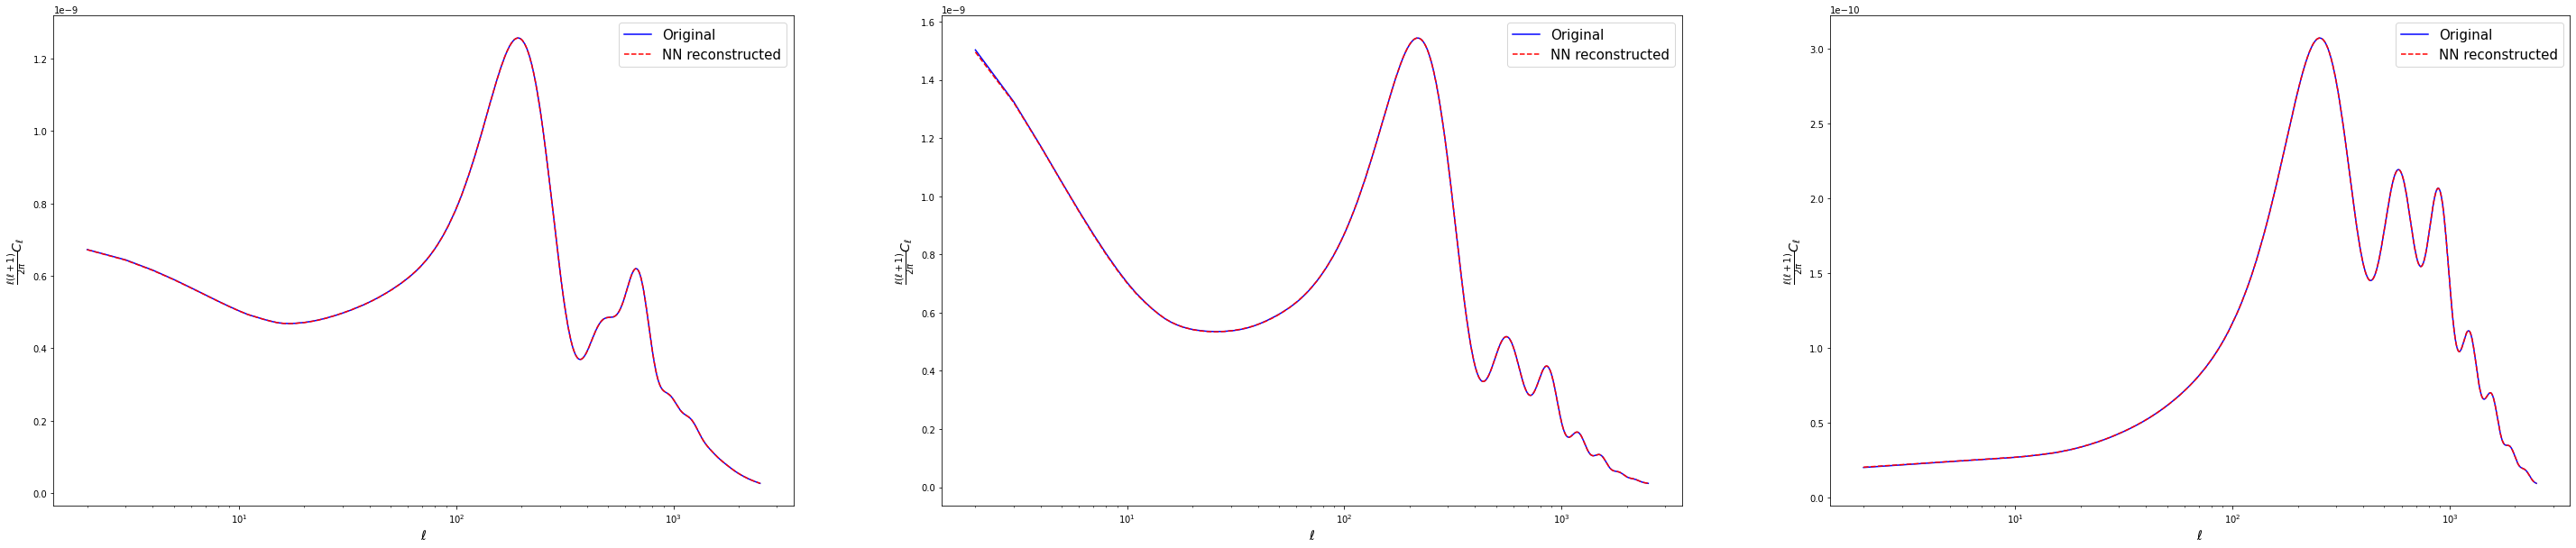

In [ ]:
from matplotlib import gridspec
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(50,10))
for i in range(3):
    pred = predicted_testing_spectra[i]*ell_range*(ell_range+1)/(2.*np.pi)
    true = testing_spectra[i]*ell_range*(ell_range+1)/(2.*np.pi)
    ax[i].semilogx(ell_range, true, 'blue', label = 'Original')
    ax[i].semilogx(ell_range, pred, 'red', label = 'NN reconstructed', linestyle='--')
    ax[i].set_xlabel('$\ell$', fontsize='x-large')
    ax[i].set_ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell$', fontsize='x-large')
    ax[i].legend(fontsize=15)
plt.savefig('examples_reconstruction_TT.pdf')

We want to plot accuracy in units of Simons Observatory (SO) noise curves. 
Start by loading SO noise curves from [the SO repository](https://github.com/simonsobs/so_noise_models) 

In [ ]:
!git clone https://github.com/simonsobs/so_noise_models

Cloning into 'so_noise_models'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 179 (delta 69), reused 147 (delta 47), pack-reused 0
Receiving objects: 100% (179/179), 7.96 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [ ]:
# load noise models from the SO noise repo
noise_levels_load = np.loadtxt('./so_noise_models/LAT_comp_sep_noise/v3.1.0/SO_LAT_Nell_T_atmv1_goal_fsky0p4_ILC_CMB.txt')
conv_factor = (2.7255e6)**2

In [ ]:
ells = noise_levels_load[:, 0]
SO_TT_noise = noise_levels_load[:, 1][:2509-40] / conv_factor
new_ells = ells[:2509-40]

In [ ]:
f_sky = 0.4
prefac = np.sqrt(2/(f_sky*(2*new_ells+1)))
denominator = prefac*(testing_spectra[:, 38:]+SO_TT_noise)  # use all of them
diff = np.abs((predicted_testing_spectra[:, 38:] - testing_spectra[:, 38:])/(denominator))

# Compute percentiles
percentiles = np.zeros((4, diff.shape[1]))

percentiles[0] = np.percentile(diff, 68, axis = 0)
percentiles[1] = np.percentile(diff, 95, axis = 0)
percentiles[2] = np.percentile(diff, 99, axis = 0)
percentiles[3] = np.percentile(diff, 99.9, axis = 0)

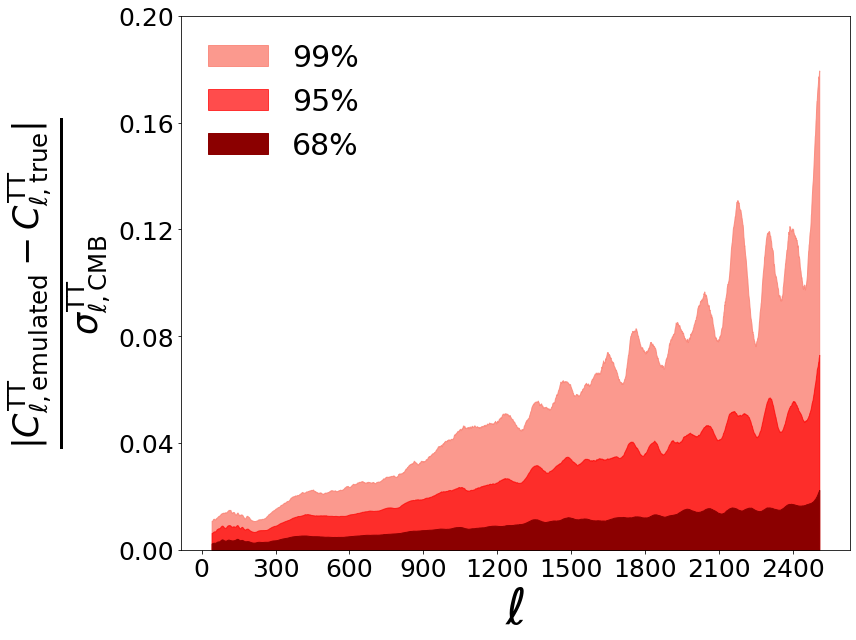

In [ ]:
plt.figure(figsize=(12, 9))
plt.fill_between(new_ells, 0, percentiles[2,:], color = 'salmon', label = '99%', alpha=0.8)
plt.fill_between(new_ells, 0, percentiles[1,:], color = 'red', label = '95%', alpha = 0.7)
plt.fill_between(new_ells, 0, percentiles[0,:], color = 'darkred', label = '68%', alpha = 1)

plt.ylim(0, 0.2)

plt.legend(frameon=False, fontsize=30, loc='upper left')
plt.ylabel(r'$\frac{| C_{\ell, \rm{emulated}}^{\rm{TT}} - C_{\ell, \rm{true}}^{\rm{TT}}|} {\sigma_{\ell, \rm{CMB}}^{\rm{TT}}}$', fontsize=50)
plt.xlabel(r'$\ell$',  fontsize=50)

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.setp(ax.get_xticklabels(), fontsize=25)
plt.setp(ax.get_yticklabels(), fontsize=25)
plt.tight_layout()
plt.savefig('./accuracy_emu_TT_wide.pdf')